<a href="https://colab.research.google.com/github/deepakri201/nlst_explore/blob/main/Exploratory_analysis_NLST_126k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook explores the 126k series NLST results.

In [1]:
#@title Enter your Project ID here
# initialize this variable with your Google Cloud Project ID!
project_name = "idc-external-018" #@param {type:"string"}

import os
os.environ["GCP_PROJECT_ID"] = project_name

!gcloud config set project $project_name

from google.colab import auth
auth.authenticate_user()

Updated property [core/project].


# Environment setup

In [2]:
import os
import sys
import time
import json
import subprocess
import glob
import shutil

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
pd.options.mode.chained_assignment = None

import seaborn as sb
import db_dtypes

from google.cloud import bigquery
from google.cloud import storage

from collections import OrderedDict

import seaborn as sns

from pathlib import Path

import random

import collections

In [33]:
!pip install bokeh==2.4.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 46.0 MB/s eta 0:00:00
  Attempting uninstall: bokeh
    Found existing installation: bokeh 3.1.1
    Uninstalling bokeh-3.1.1:
      Successfully uninstalled bokeh-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 1.2.1 requires bokeh<3.3.0,>=3.1.1, but you have bokeh 2.4.3 which is incompatible.


In [3]:
# https://docs.bokeh.org/en/latest/docs/user_guide/categorical.html
# http://jaredmmoore.com/bokeh-boxplot-color-by-factor-and-legend-outside-plot/
# https://github.com/jaredmoore/Bokeh_Plot_Examples/blob/master/Bokeh%2012.10%20Boxplot%20AutoGroup.ipynb

from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.colors import RGB
from bokeh.transform import jitter

from bokeh.models import HoverTool, PanTool, WheelZoomTool, BoxZoomTool, ResetTool, TapTool
from bokeh.models import Legend, LegendItem

from bokeh.palettes import brewer

from bokeh.layouts import row

from bokeh.io import export_png
from bokeh.io.export import get_screenshot_as_png

In [4]:
import bokeh
bokeh.__version__

'2.4.3'

# Parameterization

In [5]:
# table_id = "idc-external-025.terra.10k-series-data-061023-measurements-clinical-viewer_table_Deepa" # includes left/right laterality and smoking status
table_id_126k = "idc-external-025.terra.nlst-126k-measurements-clinical-acquisition"
table_id_10k = "idc-external-025.terra.10k-series-data-061023-measurements-clinical-viewer_table_Deepa" # includes left/right laterality and smoking status

# Functions

In [6]:
def color_list_generator(df, col):
  """

  Create a list of colors per col given a dataframe

  Arguments:
    df    : dataframe to get data from
    col   : column to use to get unique treatments.

  Returns:
    colormap   : the colormap created
    colors     : the actual colors

  Inspired by creating colors for each treatment
  Rough Source: http://bokeh.pydata.org/en/latest/docs/gallery/brewer.html#gallery-brewer
  Fine Tune Source: http://bokeh.pydata.org/en/latest/docs/gallery/iris.html

  """

  if (len(df[col].unique()))==1:
    colors = brewer["Dark2"][3][0:1] # Spectral, Dark2
  elif (len(df[col].unique()))==2:
    colors = brewer["Dark2"][3][0:2]
  elif (len(df[col].unique()))>8:
    num_colors = len(df[col].unique())
    num_colormaps = np.int32(np.ceil(num_colors/8))
    colormap_chained = brewer["Dark2"][8]*num_colormaps
    colors = colormap_chained[0:num_colors]
  else:
    colors = brewer["Dark2"][len(df[col].unique())]

  # Create a map between treatment and color.
  colormap = {i: colors[k] for k,i in enumerate(df[col].unique())}

  # sort these according to the key
  colormap = collections.OrderedDict(sorted(colormap.items()))

  # Return a list of colors for each value that we will be looking at.
  return colormap, [colormap[x] for x in df[col]]

# M vs F differences in volume of vertebrae

https://pubmed.ncbi.nlm.nih.gov/10457272/
Age- and Gender-Related Differences in Vertebral Bone Mass, Density, and Strength
F - open circles
M - filled in circles


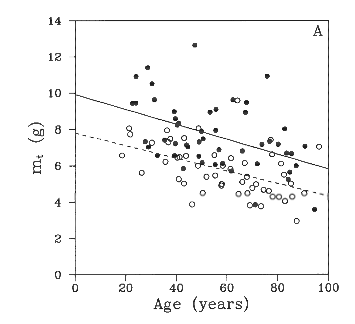

In [7]:
def create_seaborn_plot_scatterplot_gender(region, feature, table_id):

  client = bigquery.Client(project=project_name)
  print(table_id)

  query = f"""

  SELECT
     DISTINCT(SOPInstanceUID),
     age,
     gender,
     Value
  FROM
    `{table_id}`
  WHERE
      findingSite.CodeMeaning = @region AND
      Quantity.CodeMeaning = @feature;
  """

  job_config = bigquery.QueryJobConfig(query_parameters=[
                                                        bigquery.ScalarQueryParameter("region", "STRING", region),
                                                        bigquery.ScalarQueryParameter("feature", "STRING", feature)
                                                        ])
  df = client.query(query, job_config=job_config).to_dataframe()

  # Histograms of Volume values F vs M
  histogram = sns.histplot(data=df, x="Value", hue="gender")
  histogram.set(xlabel = feature, ylabel = "Count", title = feature + ' M vs F')

  return

idc-external-025.terra.nlst-126k-measurements-clinical-acquisition


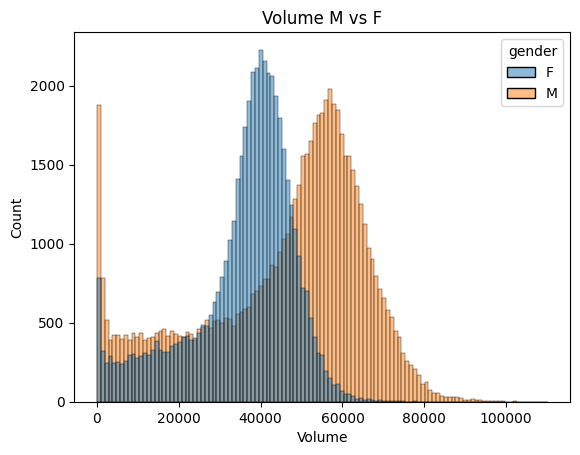

In [29]:
create_seaborn_plot_scatterplot_gender('L1 vertebra', 'Volume', table_id_126k)

idc-external-025.terra.10k-series-data-061023-measurements-clinical-viewer_table_Deepa


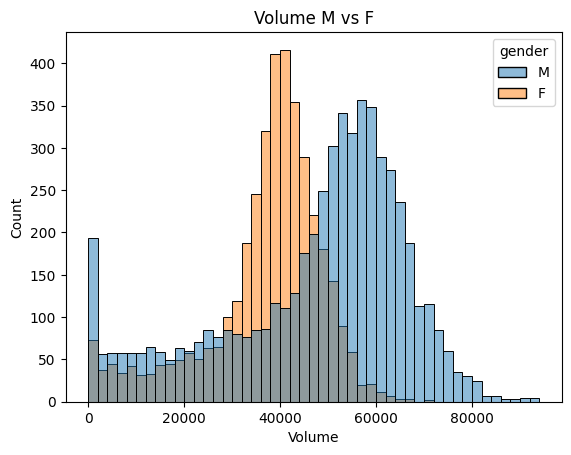

In [30]:
create_seaborn_plot_scatterplot_gender('L1 vertebra', 'Volume', table_id_10k)

In [8]:
def create_bokeh_plot_scatterplot_age(region, feature, table_id):

  client = bigquery.Client(project=project_name)
  print(table_id)

  query = f"""

    SELECT
      DISTINCT(SOPInstanceUID),
      PatientID,
      age,
      gender,
      Value,
      viewer_url
    FROM
      `{table_id}`
    WHERE
      findingSite.CodeMeaning = @region AND
      Quantity.CodeMeaning = @feature;
  """

  # df = client.query(query).to_dataframe()

  job_config = bigquery.QueryJobConfig(query_parameters=[
                                                        bigquery.ScalarQueryParameter("region", "STRING", region),
                                                        bigquery.ScalarQueryParameter("feature", "STRING", feature)
                                                        ])
  df_plot = client.query(query, job_config=job_config).to_dataframe()

  ########## create bokeh plot with ohif urls

  output_notebook()

  # set the seed so jitter will be the same for each run
  np.random.seed(0)
  random.seed(0)

  #--- create df of the feature we want to plot ---#

  new_column = [np.float32(f) for f in df_plot['Value'].values]
  df_plot['Value_numeric'] = new_column

  colormap, colors = color_list_generator(df_plot, 'gender')
  df_plot['colors'] = colors
  # cats = df_plot.gender.unique()
  cats = list(colormap.keys())
  colors = list(colormap.values())

  # --- scatterplot of age on y axis vs feature on x axis for each gender --- #
  # --- also draw regression lines for each gender --- #

  hover = HoverTool(tooltips=[
    (''.join(["(",'feature',")"]), "($y)")
  ])

  wZoom = WheelZoomTool()
  bZoom = BoxZoomTool()
  reset = ResetTool()
  tap = TapTool()
  pan = PanTool()

  p = figure(tools = [hover, wZoom, bZoom, reset, tap, pan])

  # add scatter plot
  l1 = p.circle(x='age', y='Value_numeric', source=df_plot, size=3, alpha=1, color='colors')
  legend = Legend(items=[LegendItem(label=dict(field="gender"), renderers=[l1])])
  p.add_layout(legend, 'below')

  # add best fit line for each of the genders - create dataframe for plotting
  df_plot_with_line = pd.DataFrame()
  for g in range(0,len(colors)):
    df_plot_line = df_plot[df_plot['gender']==cats[g]]
    x = np.asarray(df_plot_line['age'].values).astype(np.float32)
    y = np.asarray(df_plot_line['Value_numeric'].values)
    par = np.polyfit(x, y, 1, full=True)
    slope=par[0][0]
    intercept=par[0][1]
    y_predicted = [slope*i + intercept  for i in x]
    # add to dataframe
    df_plot_line['y_predicted'] = y_predicted
    # df_plot_with_line = pd.concat([df_plot_with_line, df_plot_line])

    l2 = p.line(x='age',y='y_predicted',source=df_plot_line, alpha=1, line_color=colors[g])



  # Add url
  url="@viewer_url"
  taptool = p.select(type=TapTool)
  taptool.callback = OpenURL(url=url)

  # Setup plot titles and such.
  p.title.text = 'Age vs ' + region + ' ' + feature
  p.xaxis.axis_label = 'Age'
  # p.xgrid.grid_line_color = None
  p.ygrid.grid_line_color = "white"
  p.grid.grid_line_width = 2
  # p.xaxis.major_label_text_font_size="0pt"
  # p.xaxis.major_label_orientation = np.pi/4
  p.yaxis.axis_label= region + ' ' + feature


  # show the plot
  show(p)



  return df_plot


In [11]:
df_plot = create_bokeh_plot_scatterplot_age("L1 vertebra", "Volume", table_id_10k)


idc-external-025.terra.10k-series-data-061023-measurements-clinical-viewer_table_Deepa


In [ ]:
# waiting for viewer url in 126k
# df_plot = create_bokeh_plot_scatterplot_age("L1 vertebra", "Volume", table_id_126k)


# Convolutional kernel analysis

In [ ]:
# SELECT
#   DISTINCT(ConvolutionKernel),
#   COUNT(DISTINCT(sourceSegmentedSeriesUID)) as num_series,
#   Manufacturer
# FROM
#   `idc-external-025.terra.nlst-126k-measurements-clinical-acquisition`
# GROUP BY
#   ConvolutionKernel,
#   Manufacturer
# ORDER BY
#   num_series DESC

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8010534/pdf/bjr.20200947.pdf

- For each of the 4 manufacturers, divide into sharp and smooth kernels
- For each study analyzed, we can keep the series that have at least 1 sharp and 1 smooth kernel, pick only 1 if more
- Pick a region - lung lobe, calculate ICC between sharp and smooth kernels across patients for a particular manufacturer
   - now divide across lung abnormality
- Bokeh plot - sharp distribution vs smooth distribution for a particular region, for a particular feature

In [8]:
sharp_kernels = ['C', 'STANDARD', 'B30f']
smooth_kernels = ['D', 'LUNG', 'B50f']

In [ ]:
# client = bigquery.Client(project=project_name)
# print(table_id)

# query = f"""
#   WITH study_conv_sharp AS(

#     SELECT
#       StudyInstanceUID,
#       sourceSegmentedSeriesUID
#     FROM
#       `idc-external-025.terra.nlst-126k-measurements-clinical-acquisition`
#     WHERE
#       Manufacturer = "GE MEDICAL SYSTEMS" AND
#       ConvolutionKernel = "STANDARD"
#   )

#   SELECT
#     table1.StudyInstanceUID,
#     table1.sourceSegmentedSeriesUID,
#     table1.ConvolutionKernel,
#     table1.Manufacturer,
#     table1.SliceThickness,
#     table1.findingSite.CodeMeaning as findingSite_CodeMeaning,
#     table1.Quantity.CodeMeaning as Quantity_CodeMeaning,
#     table1.lateralityModifier.CodeMeaning as lateralityModifier_CodeMeaning,
#     table1.Value
#   FROM
#     `idc-external-025.terra.nlst-126k-measurements-clinical-acquisition` as table1
#   JOIN
#     study_conv_sharp
#   ON
#     study_conv_sharp.StudyInstanceUID = table1.StudyInstanceUID
#   WHERE
#     table1.ConvolutionKernel = "LUNG" AND
#     findingSite.CodeMeaning = "Upper lobe of lung"
#     """

# df = client.query(query).to_dataframe()

idc-external-025.terra.nlst-126k-measurements-clinical-acquisition


# New Section

In [ ]:
df_left = df[df['lateralityModifier_CodeMeaning'=='Left']]

In [ ]:
# # Histograms of Volume values F vs M
# histogram = sns.histplot(data=df, x="Value", hue="gender")
# histogram.set(xlabel = feature, ylabel = "Count", title = feature + ' M vs F')

# Histograms of Mean values sharp vs smooth
histogram = sns.histplot(data=df_left, x="Value", hue="ConvolutionKernel")
histogram.set(xlabel = 'Convolutional Kernel', ylabel = "Count", title = 'Upper lobe of lung - left for STANDARD vs LUNG kernel for GE - Mean intensity value')